# Model Building and Evaluation

## Find the best estimator

### Import the packages

In this section, we'll build and evaluate different models to predict the Airbnb prices using the preprocessed dataset. We'll compare the performance of various regression algorithms, such as RandomForest, Lasso, and Ridge, combined with different imputers like SimpleImputer and KNNImputer.

First, let's import the necessary libraries and define some utility functions to streamline the process:

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
import copy
import matplotlib.pyplot as plt

In [2]:
import importlib
import utils.pipeline_utils
importlib.reload(utils.pipeline_utils)

from utils.pipeline_utils import (
    create_pipelines, 
    create_summary,
    calculate_metrics, 
    display_results
)


### Load the data

In [3]:
filtered_data = pd.read_csv('data/filtered_data.csv')
filtered_data.columns

Index(['City', 'Price', 'Day', 'Room Type', 'Shared Room', 'Private Room',
       'Person Capacity', 'Superhost', 'Multiple Rooms', 'Business',
       'Cleanliness Rating', 'Guest Satisfaction', 'Bedrooms',
       'City Center (km)', 'Metro Distance (km)', 'Attraction Index',
       'Normalised Attraction Index', 'Restraunt Index',
       'Normalised Restraunt Index'],
      dtype='object')

### One-hot encoding for categorical features

In [4]:
cat_features = ['City', 'Day', 'Room Type']
enc = OneHotEncoder(sparse=False, drop='first')
encoded_features = enc.fit_transform(filtered_data[cat_features])
encoded_features_df = pd.DataFrame(encoded_features, columns=enc.get_feature_names_out(cat_features))

# Drop original categorical columns and append encoded features
filtered_data = filtered_data.drop(cat_features, axis=1)
filtered_data = pd.concat([filtered_data, encoded_features_df], axis=1)

# Define X and y
X = filtered_data.drop('Price', axis=1)
y = filtered_data['Price']

# Continue with your existing code from here for splitting data, creating pipelines, and running models


/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Split the data

We split the data into training, validation, and test sets, with 80% of the data for training and 20% for testing. We further split the training data into an 80-20 split for training and validation.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=331)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((25193, 26), (25193,), (6299, 26), (6299,), (7873, 26), (7873,))

### Create pipelines and fit data

We defined two imputers, SimpleImputer and KNNImputer, and three models, RandomForestRegressor, Lasso, and Ridge. This resulted in a total of six combinations of imputers and models.

In [6]:
pipes = create_pipelines()
pipes

{'simple_imputer+rf': Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='most_frequent')),
                 ('rf', RandomForestRegressor(min_samples_leaf=5))]),
 'simple_imputer+lasso': Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='most_frequent')),
                 ('lasso', Lasso())]),
 'simple_imputer+ridge': Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='most_frequent')),
                 ('ridge', Ridge())]),
 'knn_imputer+rf': Pipeline(steps=[('knn_imputer', KNNImputer()),
                 ('rf', RandomForestRegressor(min_samples_leaf=5))]),
 'knn_imputer+lasso': Pipeline(steps=[('knn_imputer', KNNImputer()), ('lasso', Lasso())]),
 'knn_imputer+ridge': Pipeline(steps=[('knn_imputer', KNNImputer()), ('ridge', Ridge())])}

We created pipelines for each combination of imputer and model to streamline the preprocessing and modeling process. We fit each pipeline to the training data.

In [7]:
for pipe_name, pipe in pipes.items():
    pipe.fit(X_train, y_train)

We defined a parameter grid for cross-validation, specifying the hyperparameters to be tuned for each model.

In [8]:
cv_param_grid_all = {
    "rf__min_samples_leaf": [1, 3, 5, 10],
    "lasso__alpha": np.logspace(-2, 2, 10),
    "knn_imputer__n_neighbors": [2, 5, 10],
    "ridge__alpha": np.logspace(-3, 7, 10)
}

For each pipeline, we performed a grid search with cross-validation to find the optimal hyperparameters. We stored the best-performing pipeline and calculated the validation score.

In [9]:
valid_errs = {}
tuned_pipelines = {}
ypred_valid = {}

for pipe_name, pipe in pipes.items():
    cv_param_grid = {key: cv_param_grid_all[key] for key in cv_param_grid_all.keys() if key.startswith(tuple(pipe.named_steps.keys()))}
    pipe_search = GridSearchCV(pipe, cv_param_grid)
    pipe_search.fit(X_train, y_train)
    valid_errs[pipe_name] = pipe_search.score(X_valid, y_valid)
    tuned_pipelines[pipe_name] = copy.deepcopy(pipe_search)
    ypred_valid[pipe_name] = pipe.predict(X_valid)

We calculated the mean squared error (MSE) and mean absolute error (MAE) for each pipeline to evaluate their performance on the validation set.

###  Results

In [10]:
summary = create_summary(valid_errs, y_valid, ypred_valid)
summary.to_csv('results/summary.csv')
summary

,Valid Errors,MSE,MAE
Model,,,
simple_imputer+rf,0.741314,3423.600482,41.317972
simple_imputer+lasso,0.574950,5854.422403,56.484180
simple_imputer+ridge,0.574950,4861.623952,51.632038
knn_imputer+rf,0.742253,3423.600482,41.317972
knn_imputer+lasso,0.574950,5854.422403,56.484180
knn_imputer+ridge,0.574950,4861.623952,51.632038



Based on the results, the best model seems to be knn_imputer+rf	 with the highest validation score. We will use this model to make predictions on the test data and evaluate its performance using MSE and MAE.

## Test data use the best estimator

In [11]:
best_model = tuned_pipelines['knn_imputer+rf']

# Make predictions on the test data
y_pred_test = best_model.predict(X_test)

# Calculate evaluation metrics for test data
test_mse, test_mae, test_r2 = calculate_metrics(y_test, y_pred_test)

# Display the results in a table format
results_df = display_results(test_mse, test_mae, test_r2)
results_df.to_csv('results/results_df.csv')
results_df

,R-squared,MSE,MAE
Model,,,
knn_imputer+rf,0.744491,2880.713519,36.672181


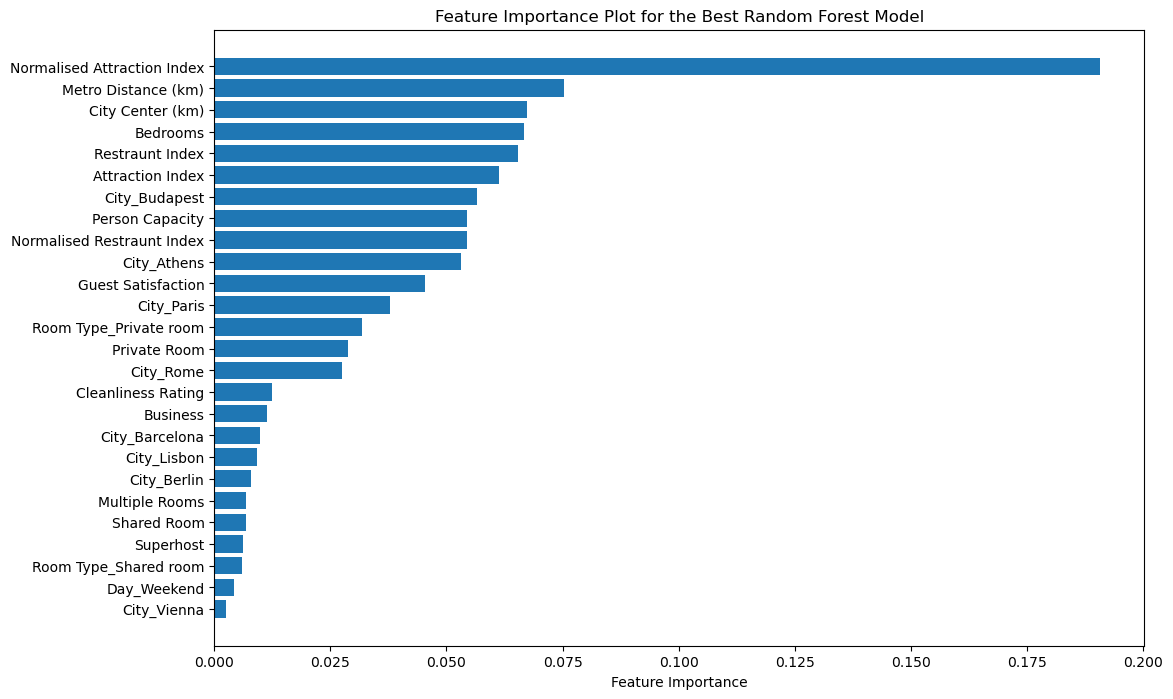

In [12]:
# Extract the best estimator from GridSearchCV and get the Random Forest model
best_rf_model = best_model.best_estimator_.named_steps['rf']

# Extract the feature importances
importances = best_rf_model.feature_importances_

# Get the feature names from the preprocessed dataset
feature_names = X_train.columns

# Sort the importances in descending order and match them with the corresponding feature names
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Create the feature importance plot
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, sorted_importances, align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot for the Best Random Forest Model')
plt.gca().invert_yaxis()  # Show the most important features at the top
plt.savefig('figures/feature_importance_plot', bbox_inches='tight')
plt.show()
